In [114]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import warnings
#warnings.filterwarnings('ignore')
pd.set_option("future.no_silent_downcasting", True)

seed = 1234
np.random.seed(seed)  

In [116]:
columns = ["age", "workclass", "fnlwgt", "education", "education_num", "marital_status",
           "occupation", "relationship", "race", "sex", "capital_gain", "capital_loss",
           "hours_per_week", "native_country", "income"]

# Read train data 
train_df = pd.read_csv("adult/adult.data", names=columns, sep=",", header=None)

# test data 
test_df = pd.read_csv("adult/adult.test", names=columns, sep=",", header=None, skiprows=1)

# Replace ` ?` with `NaN`
train_df.replace(' ?', np.nan, inplace=True)
test_df.replace(' ?', np.nan, inplace=True)

## EDA

In [119]:
print(train_df.shape)
train_df.head()

(32561, 15)


,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [121]:
# print(test_df.shape)
# test_df.head()

In [123]:
# train_df.info();

In [125]:
# Summary statistics for numerical columns
# print(train_df.describe());

In [127]:
# Histogram
# numerical_features = ['age', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week']
# train_df[numerical_features].hist(figsize=(10, 8));

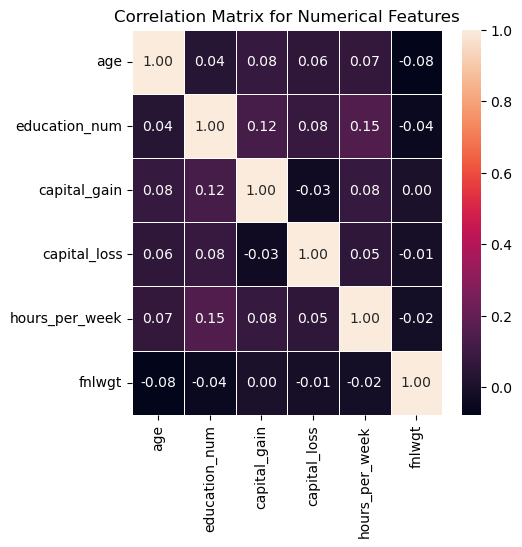

In [129]:
# CORRELATION MATRIX /HEATMAP
numerical_features = ['age', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week', "fnlwgt"]

correlation_matrix = train_df[numerical_features].corr()

plt.figure(figsize=(5, 5))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix for Numerical Features")
plt.show()

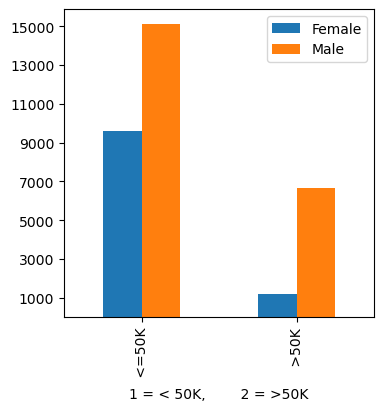

In [131]:
# income vs gender
class_sex = pd.crosstab(train_df['income'], train_df['sex'])
class_sex.plot(kind='bar', figsize=(4, 4))

plt.legend(['Female', 'Male'])
plt.xlabel('1 = < 50K,        2 = >50K')
plt.yticks(np.arange(1000,17000,2000));

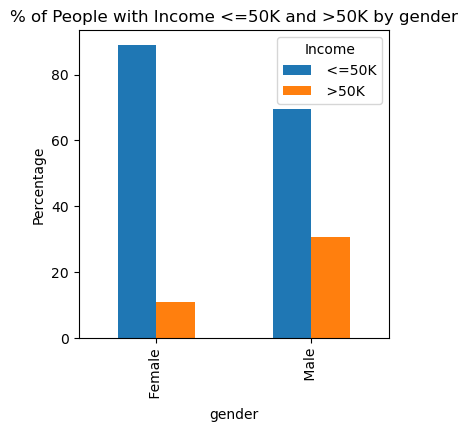

In [133]:
# Group by gender and income
gender = train_df.groupby(['sex', 'income']).size().unstack()
gender = gender.div(gender.sum(axis=1), axis=0) * 100

#gender.plot(kind='bar', stacked = True, figsize=(5, 5))
gender.plot(kind='bar',  figsize=(4, 4))

plt.title('% of People with Income <=50K and >50K by gender')
plt.xlabel('gender')
plt.ylabel('Percentage')
plt.legend(title='Income', loc='upper right');

In [135]:
# Out of total male 30% of them earn salary more than 50K 
#while around 15% female earn more than 50K. 

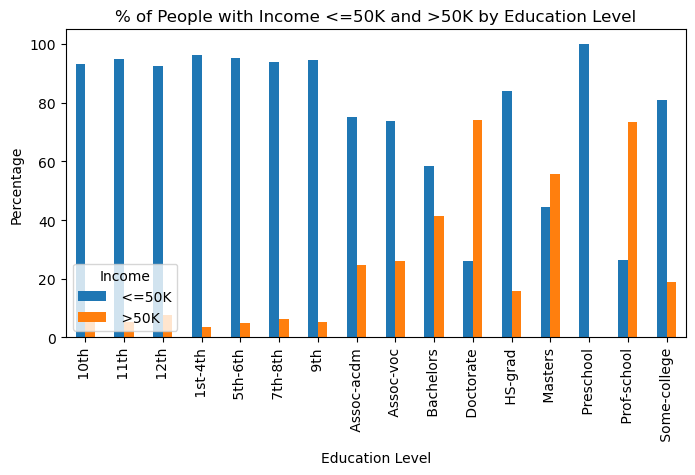

In [137]:
# Group by education and income
education = train_df.groupby(['education', 'income']).size().unstack()
education = education.div(education.sum(axis=1), axis=0) * 100

#education.plot(kind='bar', stacked=True, figsize=(8, 6))
education.plot(kind='bar', figsize=(8, 4))

plt.title('% of People with Income <=50K and >50K by Education Level')
plt.xlabel('Education Level')
plt.ylabel('Percentage')
plt.legend(title='Income', loc='lower left');

# preprocessing

In [140]:
# number of missing values in train data
#print(train_df.isnull().sum())  

In [142]:
#number of missing values in test data
print(test_df.isnull().sum())  


age                 0
workclass         963
fnlwgt              0
education           0
education_num       0
marital_status      0
occupation        966
relationship        0
race                0
sex                 0
capital_gain        0
capital_loss        0
hours_per_week      0
native_country    274
income              0
dtype: int64


In [144]:
# remove any whitespace 
train_df = train_df.apply(lambda col: col.str.strip() if col.dtype == 'object' else col)

# remove any whitespace 
test_df = test_df.apply(lambda col: col.str.strip() if col.dtype == 'object' else col)

# binary mapping for target labels
train_df['income'] = train_df['income'].map({'<=50K': 0, '>50K': 1})

# target labels of adult.test end with ".", we remove "."
test_df['income'] = test_df['income'].str.strip().str.replace('.', '')

# binary mapping for target labels
test_df['income'] = test_df['income'].map({'<=50K': 0, '>50K': 1})


In [146]:
#  heatmap example
# pivot_table = train_df.pivot_table(index='education', columns='occupation', values='income', aggfunc='mean')

# plt.figure(figsize=(12, 8))
# sns.heatmap(pivot_table, annot=True, cmap='YlGnBu', fmt='.1f')
# plt.title('income by Education and Occupation')
# plt.show()

In [148]:
# education_num col is just a numerical encoding of the education column,
# representing the order of education levels. 
# keeping both columns might create unnecessary redundancy in the dataset.
# so we drop the education col
train_df = train_df.drop(columns=['education'])
test_df = test_df.drop(columns=['education'])

# We decided to drop the fnlwgt column because it represents the final weight 
# assigned during data collection to make the dataset representative of the population.
#This column is not a meaningful predictor of an individual's income, as it reflects sampling 
# adjustments rather than personal attributes. 
#Including it in the analysis could introduce unnecessary noise without providing valuable 
#information for the task of income prediction.

train_df = train_df.drop(columns=['fnlwgt'])
test_df = test_df.drop(columns=['fnlwgt'])

In [150]:
#ignore this for now, it didnt work

# marital_status_mapping = {
#     'Never-married': 'Single',
#     'Married-civ-spouse': 'Married',
#     'Divorced': 'Single',
#     'Married-spouse-absent': 'Married',
#     'Separated': 'Single',
#     'Married-AF-spouse': 'Married',
#     'Widowed': 'Single'
# }

# # Replace the marital_status column based on the mapping
# train_df['marital_status'] = train_df['marital_status'].replace(marital_status_mapping)
# test_df['marital_status'] = test_df['marital_status'].replace(marital_status_mapping)

# print(train_df['marital_status'].unique())
# print(test_df['marital_status'].unique())

### Splitting train_df into train & validation sets

In [153]:
# Features
X = train_df.drop(columns=["income"])
# Target labels
y = train_df["income"]  

X_train, X_val, y_train, y_val  = train_test_split(X, y, test_size=0.15, random_state=seed, shuffle=True)
  

In [155]:
print(X.shape)
print(X_train.shape)
print(X_val.shape)

(32561, 12)
(27676, 12)
(4885, 12)


In [157]:
X_test = test_df.drop(columns=['income'])
y_test = test_df['income']


### converting categorical data to numerical values (Encoding)

If we perform encoding before the train-test split, the model will see information from the entire dataset, including the test data, during encoding. This could lead to data leakage, where the model has prior knowledge of the test data.

In [160]:
# one hot encoder 
#https://www.geeksforgeeks.org/ml-one-hot-encoding/

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

categorical_features =[ 'workclass',  'marital_status', 'occupation',
                        'relationship', 'race', 'sex',  'native_country']

# # Initialize the OneHotEncoder
# encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop='first') 

# # Apply the encoder to the categorical features using a ColumnTransformer
# preprocessor = ColumnTransformer(
#     transformers=[('cat', encoder, categorical_features)],
#     remainder='passthrough'  
# )

# # Fit and transform the training set, then transform validation and test sets
# X_train = preprocessor.fit_transform(X_train)
# X_val = preprocessor.transform(X_val)
# X_test = preprocessor.transform(X_test)


# code for one hot encoding w pd dummies
X_train = pd.get_dummies(X_train, columns=categorical_features)
X_val = pd.get_dummies(X_val, columns=categorical_features)
X_test = pd.get_dummies(X_test, columns=categorical_features)

X_train, X_val = X_train.align(X_val, join='left', axis=1)
X_train, X_test = X_train.align(X_test, join='left', axis=1)

In [162]:
print("shapes after encoding:")
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

shapes after encoding:
(27676, 87)
(4885, 87)
(16281, 87)


### handling missing values

In [165]:
# we impute the missing values in the dataset, after splitting the data. 
# This avoids data leakage.
# https://medium.com/@odil.tokhirov/how-to-deal-with-missing-and-categorical-values-in-data-used-for-machine-learning-28e8b95539bf#:~:text=So%20when%20it%20appears%20in,avoids%20something%20called%20data%20leakage.

from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='mean') 
X_train = imputer.fit_transform(X_train)

# using the same imputer for X_val and X_test
X_val = imputer.transform(X_val)
X_test = imputer.transform(X_test)

### Feature scaling

In [168]:
# NO FEAUTURE SCALING REQUIRED FOR TREE BASED MODELS, need for logisitc regression only
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

## Random Forest

In [212]:
# BASELINE model

learner = RandomForestClassifier(random_state=seed)
learner.fit(X_train, y_train)

#  training  error rate
train_err = (y_train!= learner.predict(X_train)).mean()
print(f"\nTraining error rate : ", train_err)

# validation error rate
val_err = (y_val!= learner.predict(X_val)).mean()
print(f"\nvalidation error rate : ", val_err)

# test error rate
test_err = (y_test!= learner.predict(X_test)).mean()
print(f"\ntest error rate : ", test_err)

# Perform cross-validation
# cv_scores = cross_val_score(learner, X_train, y_train, cv=5, scoring='accuracy')
# # Print cross-validation results
# print(f"\nCross-validation scores: {cv_scores}")
# print(f"Mean CV score: {cv_scores.mean()}")
# print(f"Mean CV error: {1-cv_scores.mean()}")



Training error rate :  0.022329816447463506

validation error rate :  0.1535312180143296

test error rate :  0.15238621706283398


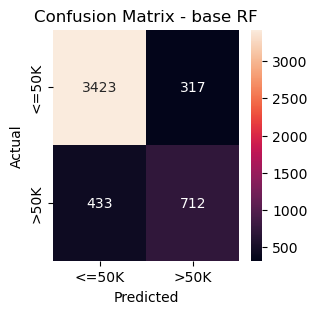


Base Model Accuracy: 0.85
Base Model Precision: 0.69
Base Model Recall: 0.62
Base Model F1-Score: 0.66


In [213]:
y_pred_val = learner.predict(X_val)

cm = confusion_matrix(y_val, y_pred_val)

plt.figure(figsize=(3, 3))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=['<=50K', '>50K'], yticklabels=['<=50K', '>50K'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - base RF')
plt.show()


base_accuracy = accuracy_score(y_val, y_pred_val)
base_precision = precision_score(y_val, y_pred_val, average='binary')
base_recall = recall_score(y_val, y_pred_val, average='binary')
base_f1 = f1_score(y_val, y_pred_val, average='binary')

print(f"\nBase Model Accuracy: {base_accuracy:.2f}")
print(f"Base Model Precision: {base_precision:.2f}")
print(f"Base Model Recall: {base_recall:.2f}")
print(f"Base Model F1-Score: {base_f1:.2f}")

In [1683]:
#learner?

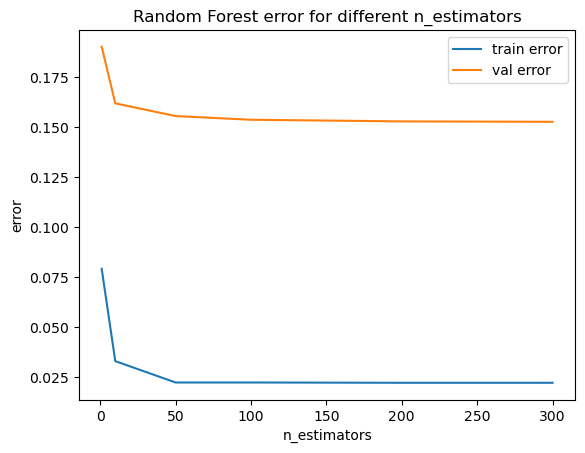

In [50]:
# number of trees to use in the ensemble
n_estimators = [1, 10, 50, 100,200,300]

train_errors = []
val_errors = []

for n in n_estimators: 

     RF = RandomForestClassifier( 
                     n_estimators=n,
                     random_state=seed)

     RF.fit(X_train, y_train)

     # Compute the training  error rates
     train_err = (y_train!= RF.predict(X_train)).mean()
     train_errors.append(train_err)

     # Compute the validation error rates
     val_err = (y_val!= RF.predict(X_val)).mean()
     val_errors.append(val_err)

# Plot the resulting performance as a function of n estimate
plt.plot(n_estimators , train_errors,  label = 'train error');
plt.plot(n_estimators , val_errors,    label = 'val error');

plt.xlabel('n_estimators')
plt.ylabel('error')
plt.title('Random Forest error for different n_estimators')
plt.legend()
plt.show()

In [1875]:
# We can see that the fit of the random forest models (given multiple ensemble members) a single tree

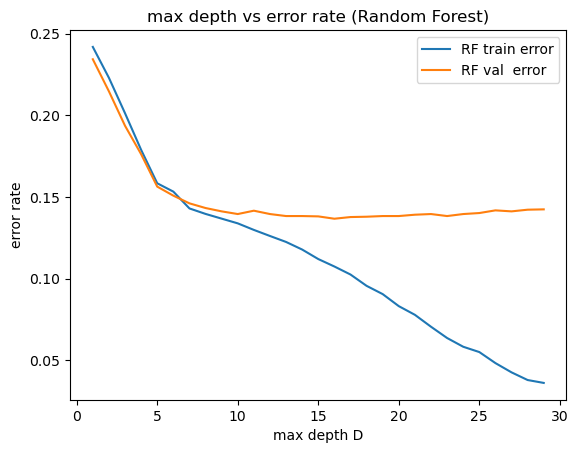

In [48]:
RF_train_err_d = []
RF_val_err_d = []

depth = list(range(1, 30))

for d in depth:
    learner = RandomForestClassifier(
    max_depth=d, 
    random_state=seed)
    
    learner.fit(X_train,y_train);

    # Compute the training  error rates
    train_err = (y_train!= learner.predict(X_train)).mean()
    RF_train_err_d.append(train_err)

    # Compute the validation error rates
    val_err = (y_val!= learner.predict(X_val)).mean()
    RF_val_err_d.append(val_err)

# Plot the resulting performance as a function of depth d
plt.plot(depth , RF_train_err_d,  label = 'RF train error');
plt.plot(depth , RF_val_err_d,    label = 'RF val  error');

plt.title("max depth vs error rate (Random Forest)");
plt.xlabel("max depth D");
plt.ylabel("error rate");
plt.legend();

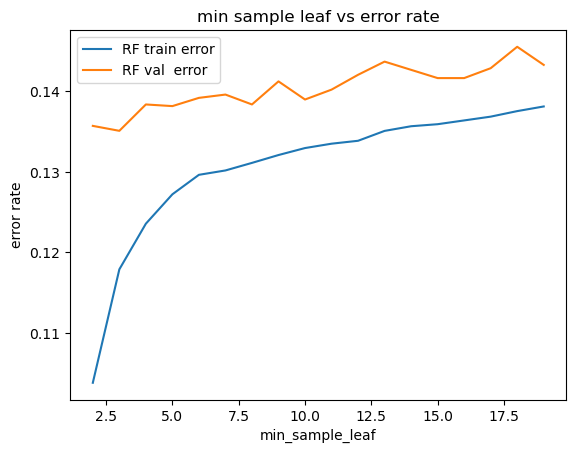

In [104]:
RF_train_err_msl = []
RF_val_err_msl = []
min_sample_leaf =  list(range(2, 20))

# creating values
# for i in range(1,6): 
#     min_sample_leaf.append(2**i)
    
for msl in min_sample_leaf: 
    
    learner = RandomForestClassifier(
    #max_depth=10,  
    min_samples_leaf=msl,  
    random_state=seed)
    
    learner.fit(X_train,y_train);

    # Compute the training  error rates
    train_err = (y_train!= learner.predict(X_train)).mean()
    RF_train_err_msl.append(train_err)

    # Compute the validation error rates
    val_err = (y_val!= learner.predict(X_val)).mean()
    RF_val_err_msl.append(val_err)

# Plot the resulting performance as a function of min sample leaf
plt.plot(min_sample_leaf , RF_train_err_msl,  label = 'RF train error');
plt.plot(min_sample_leaf , RF_val_err_msl,    label = 'RF val  error');
#plt.xscale('log', base=2)

plt.title("min sample leaf vs error rate");
plt.xlabel("min_sample_leaf");
plt.ylabel("error rate");
plt.legend();

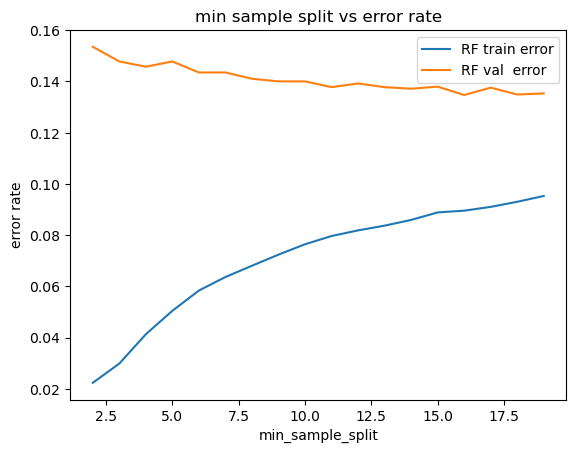

In [108]:
RF_train_err_mss = []
RF_val_err_mss = []
min_sample_split =  list(range(2, 20))
    
for mss in min_sample_split: 
    
    learner = RandomForestClassifier(
    #max_depth=10,  # Restrict depth
    min_samples_split=mss,  
    random_state=seed)
    
    learner.fit(X_train,y_train);

    # Compute the training  error rates
    train_err = (y_train!= learner.predict(X_train)).mean()
    RF_train_err_mss.append(train_err)

    # Compute the validation error rates
    val_err = (y_val!= learner.predict(X_val)).mean()
    RF_val_err_mss.append(val_err)

# Plot the resulting performance as a function of min sample leaf
plt.plot(min_sample_split , RF_train_err_mss,  label = 'RF train error');
plt.plot(min_sample_split , RF_val_err_mss,    label = 'RF val  error');
#plt.xscale('log', base=2)

plt.title("min sample split vs error rate");
plt.xlabel("min_sample_split");
plt.ylabel("error rate");
plt.legend();

In [110]:
train_err = []
val_err = []

max_f =  ['sqrt', 'log2', 0.25, 0.5, 0.75]

for mf in max_f:
    learner = RandomForestClassifier(
    max_features=mf,   
    random_state=seed)
    
    learner.fit(X_train,y_train);

    # Compute the training  error rates
    train_err = (y_train!= learner.predict(X_train)).mean()
    print("train err for ", mf, " : ", train_err)

    # Compute the validation error rates
    val_err = (y_val!= learner.predict(X_val)).mean()
    print("val err for ", mf, " : ", val_err)

train err for  sqrt  :  0.022329816447463506
val err for  sqrt  :  0.1535312180143296
train err for  log2  :  0.022257551669316374
val err for  log2  :  0.15578300921187307
train err for  0.25  :  0.022257551669316374
val err for  0.25  :  0.14882292732855681
train err for  0.5  :  0.02222141928024281
val err for  0.5  :  0.15087001023541455
train err for  0.75  :  0.02229368405838994
val err for  0.75  :  0.15066530194472877


In [41]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import warnings
#warnings.filterwarnings('ignore')

# param_grid = {
#     'n_estimators': [100,200],
#     'max_depth': [7,10,14],
#     'min_samples_split': [6,9],
#     'min_samples_leaf': [5,10,12]
# }

# param_grid = {
#     'n_estimators': [100, 200],
#     'max_depth': [5, 10, 15, None],
#     'max_features': ['sqrt', 'log2',0.25, 0.5, 0.75],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 5],
# }

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5,10,15],
    'max_features': ['auto', 'sqrt', 'log2',  0.5]
}

grid_search = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

# random_search = RandomizedSearchCV(
#     estimator=RandomForestClassifier(),
#     param_distributions=param_grid,
#     n_iter=50,  # Number of parameter settings sampled
#     cv=3,       # Number of cross-validation folds
#     random_state=seed,
#     n_jobs=-1   # Use all available cores
# )
# random_search.fit(X_train, y_train)

# print("Best parameters:", random_search.best_params_)
# print("Best score:", random_search.best_score_)

h


/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
45 fits failed out of a total of 180.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
45 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/opt/anaconda3/lib/python3.12/site-pac

Best parameters: {'max_depth': 15, 'max_features': 0.5, 'n_estimators': 200}
Best score: 0.8647930928249552


In [ ]:
print("Best parameters:", random_search.best_params_)
print("Best score:", random_search.best_score_)


## optimal model

In [230]:
learner = RandomForestClassifier(random_state=seed, n_estimators = 200, max_depth = 15, max_features = 0.5)
learner.fit(X_train, y_train)

#  training  error rate
train_err = (y_train!= learner.predict(X_train)).mean()
print(f"\nTraining error rate : ", train_err)

# validation error rate
val_err = (y_val!= learner.predict(X_val)).mean()
print(f"\nvalidation error rate : ", val_err)

# test error rate
test_err = (y_test!= learner.predict(X_test)).mean()
print(f"\ntest error rate : ", test_err)



Training error rate :  0.09098135568723804

validation error rate :  0.13490276356192427

test error rate :  0.1334070388796757


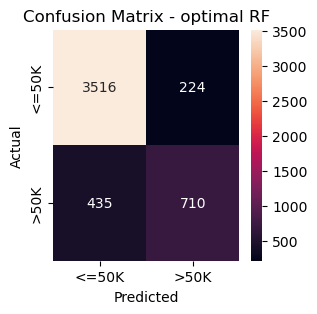


optima Model Accuracy: 0.87
optimal Model Precision: 0.76
optimal Model Recall: 0.62
optimal Model F1-Score: 0.68


In [223]:
y_pred_val = learner.predict(X_val)

cm = confusion_matrix(y_val, y_pred_val)

plt.figure(figsize=(3, 3))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=['<=50K', '>50K'], yticklabels=['<=50K', '>50K'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - optimal RF')
plt.show()

optimal_accuracy = accuracy_score(y_val, y_pred_val)
optimal_precision = precision_score(y_val, y_pred_val, average='binary')
optimal_recall = recall_score(y_val, y_pred_val, average='binary')
optimal_f1 = f1_score(y_val, y_pred_val, average='binary')

print(f"\noptima Model Accuracy: {optimal_accuracy:.2f}")
print(f"optimal Model Precision: {optimal_precision:.2f}")
print(f"optimal Model Recall: {optimal_recall:.2f}")
print(f"optimal Model F1-Score: {optimal_f1:.2f}")

## Cross Validation

In [107]:
# Perform cross-validation
cv_scores = cross_val_score(learner, X_train, y_train, cv=5, scoring='accuracy') 

print(f"Cross-validation scores: {cv_scores}")
print(f"Mean CV score: {cv_scores.mean()}")
print(f"Mean CV error: {1-cv_scores.mean()}")

Cross-validation scores: [0.85278179 0.87154472 0.86865402 0.86955736 0.86666667]
Mean CV score: 0.8658409112270313
Mean CV error: 0.13415908877296867


## Gradient Boost

In [386]:
# https://medium.com/@24littledino/xgboost-classification-in-python-f29cc2c50a9b
import xgboost as xgb

xgboost= xgb.XGBClassifier(
    random_state=seed)

xgboost.fit(X_train, y_train)

# Compute the training  error rates
train_err = (y_train!= xgboost.predict(X_train)).mean()
print(f"\nTraining error rate : ", train_err)

# Compute the validation error rates
val_err = (y_val!= xgboost.predict(X_val)).mean()
print(f"\nvalidation error rate : ", val_err)

# Compute the test error rates
test_err = (y_test!= xgboost.predict(X_test)).mean()
print(f"\ntest error rate : ", test_err)


cv_scores = cross_val_score(xgboost, X_train, y_train, cv=5, scoring='accuracy') 

print(f"\nCross-validation scores: {cv_scores}")
print(f"Mean CV score: {cv_scores.mean()}")
print(f"Mean CV error: {1-cv_scores.mean()}")


Training error rate :  0.10510911981500216

validation error rate :  0.13244626407369497

test error rate :  0.12812480805847307

Cross-validation scores: [0.85928468 0.87443541 0.87768744 0.87299006 0.87118338]
Mean CV score: 0.8711161956754442
Mean CV error: 0.12888380432455582


In [73]:
# Gradient boosting models generally outperform random forests
# due to their ability to focus on misclassified samples

In [383]:
#xgboost?

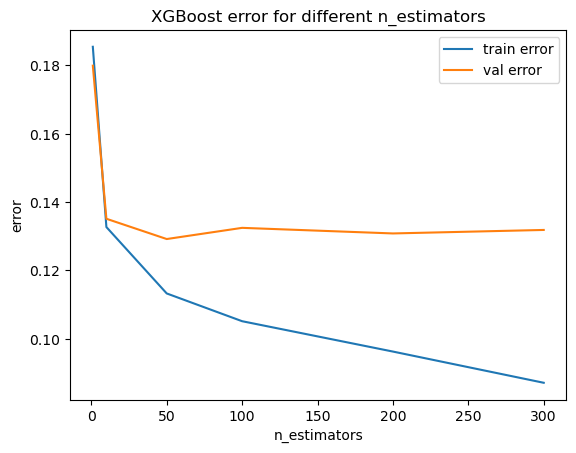

In [238]:
import xgboost as xgb

# number of trees to use in the ensemble
n_estimators = [1, 10, 50, 100,200,300]

train_errors = []
val_errors = []

for n in n_estimators: 

     xg = xgb.XGBClassifier(n_estimators=n, random_state=seed)

     xg.fit(X_train, y_train)

     # Compute the training  error rates
     train_err = (y_train!= xg.predict(X_train)).mean()
     train_errors.append(train_err)

     # Compute the validation error rates
     val_err = (y_val!= xg.predict(X_val)).mean()
     val_errors.append(val_err)

# Plot the resulting performance as a function of n estimate
plt.plot(n_estimators , train_errors,  label = 'train error');
plt.plot(n_estimators , val_errors,    label = 'val error');

plt.xlabel('n_estimators')
plt.ylabel('error')
plt.title('XGBoost error for different n_estimators')
plt.legend()
plt.show()

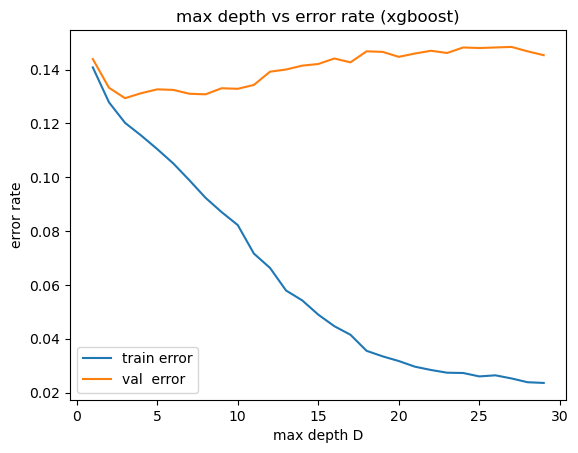

In [244]:
train_err_d = []
val_err_d = []

depth = list(range(1, 30))

for d in depth:
    learner = xgb.XGBClassifier(max_depth = d,
                      random_state=seed)
    
    learner.fit(X_train,y_train);

    # Compute the training  error rates
    train_err = (y_train!= learner.predict(X_train)).mean()
    train_err_d.append(train_err)

    # Compute the validation error rates
    val_err = (y_val!= learner.predict(X_val)).mean()
    val_err_d.append(val_err)

# Plot the resulting performance as a function of depth d
plt.plot(depth , train_err_d,  label = 'train error');
plt.plot(depth , val_err_d,    label = 'val  error');

plt.title("max depth vs error rate (xgboost)");
plt.xlabel("max depth D");
plt.ylabel("error rate");
plt.legend();

In [268]:
from sklearn.model_selection import GridSearchCV

param_grid = {'max_depth': list(range(1, 15))}
grid_search = GridSearchCV(estimator=xgb.XGBClassifier(), param_grid=param_grid, scoring='accuracy', cv=5)
grid_search.fit(X_train, y_train)

print("Best Lambda:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Best Lambda: {'max_depth': 4}
Best Score: 0.874006780289383


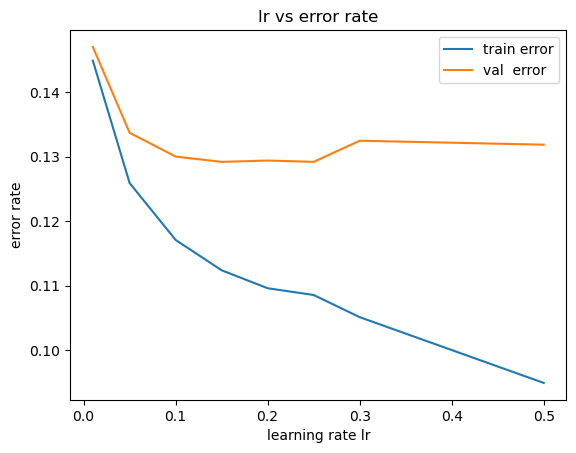

In [274]:
train_err_lr= []
val_err_lr = []

learning_rate = [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.5]

for lr in learning_rate:
    learner = xgb.XGBClassifier(learning_rate = lr,
                      random_state=seed)
    
    learner.fit(X_train,y_train);

    # Compute the training  error rates
    train_err = (y_train!= learner.predict(X_train)).mean()
    train_err_lr.append(train_err)

    # Compute the validation error rates
    val_err = (y_val!= learner.predict(X_val)).mean()
    val_err_lr.append(val_err)

# Plot the resulting performance as a function of depth d
plt.plot(learning_rate , train_err_lr,  label = 'train error');
plt.plot(learning_rate , val_err_lr,    label = 'val  error');

plt.title("lr vs error rate");
plt.xlabel("learning rate lr");
plt.ylabel("error rate");
plt.legend();

In [286]:
from sklearn.model_selection import GridSearchCV

param_grid = {'reg_lambda': [0.1, 1, 5, 10]}
grid_search = GridSearchCV(estimator=xgb.XGBClassifier(), param_grid=param_grid, scoring='accuracy', cv=5)
grid_search.fit(X_train, y_train)

print("Best Lambda:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)


Best Lambda: {'reg_lambda': 10}
Best Score: 0.8733203184151301


In [288]:
param_grid = {'reg_alpha': [0, 0.1, 1, 5]}
grid_search = GridSearchCV(estimator=xgb.XGBClassifier(), param_grid=param_grid, scoring='accuracy', cv=5)
grid_search.fit(X_train, y_train)

print("Best Alpha:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)


Best Alpha: {'reg_alpha': 0.1}
Best Score: 0.8725977097921269


In [2963]:
param_grid = {'gamma': [0, 0.1, 1, 5]}
grid_search = GridSearchCV(estimator=xgb.XGBClassifier(), param_grid=param_grid, scoring='accuracy', cv=5)
grid_search.fit(X_train, y_train)

print("Best Gamma:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)


Best Gamma: {'gamma': 1}
Best Score: 0.8730312096955266


In [292]:
param_grid = {
    'reg_lambda': [1, 5, 10],
    'reg_alpha': [0, 0.1, 1]
    #'gamma': [0, 0.1, 1]
}
grid_search = GridSearchCV(estimator=xgb.XGBClassifier(), param_grid=param_grid, scoring='accuracy', cv=5)
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)


Best Parameters: {'reg_alpha': 0, 'reg_lambda': 10}
Best Score: 0.8733203184151301


In [366]:
param_grid = {
    'n_estimators': [100],
    'max_depth' : [4] ,
    'learning_rate': [0.25], 
    'reg_lambda': [1, 5, 10],
    'reg_alpha': [0, 0.1, 1], 
    #'gamma': [0, 0.1, 1]
}
grid_search = GridSearchCV(estimator=xgb.XGBClassifier(), param_grid=param_grid, scoring='accuracy', cv=5)
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)


Best Parameters: {'learning_rate': 0.25, 'max_depth': 4, 'n_estimators': 100, 'reg_alpha': 0.1, 'reg_lambda': 1}
Best Score: 0.8733564129475593


## optimal xgboost model

In [388]:
xgboost= xgb.XGBClassifier(
    max_depth =4,
    learning_rate = 0.25,    
    #gamma = 0,
    reg_alpha = 0.1,
    reg_lambda = 1,
    #n_estimators = 100,
    random_state=seed)

xgboost.fit(X_train, y_train)

# Compute the training  error rates
train_err = (y_train!= xgboost.predict(X_train)).mean()
print(f"\nTraining error rate : ", train_err)

# Compute the validation error rates
val_err = (y_val!= xgboost.predict(X_val)).mean()
print(f"\nvalidation error rate : ", val_err)

# Compute the test error rates
test_err = (y_test!= xgboost.predict(X_test)).mean()
print(f"\ntest error rate : ", test_err)


cv_scores = cross_val_score(xgboost, X_train, y_train, cv=5, scoring='accuracy') 

print(f"\nCross-validation scores: {cv_scores}")
print(f"Mean CV score: {cv_scores.mean()}")
print(f"Mean CV error: {1-cv_scores.mean()}")


Training error rate :  0.11750252926723515

validation error rate :  0.12835209825997954

test error rate :  0.1265892758430072

Cross-validation scores: [0.86127168 0.87895212 0.87804878 0.8767841  0.87172538]
Mean CV score: 0.8733564129475593
Mean CV error: 0.12664358705244072


# Logistic Regression

In [1372]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_train, y_train)


# Compute the training  error rates
train_err = (y_train!= model.predict(X_train)).mean()
print(f"\nTraining error rate : ", train_err)

# Compute the validation error rates
val_err = (y_val!= model.predict(X_val)).mean()
print(f"\nvalidation error rate : ", val_err)

# Compute the tes error rates
test_err = (y_test!= model.predict(X_test)).mean()
print(f"\ntest error rate : ", test_err)


Training error rate :  0.14583032230091053

validation error rate :  0.15516888433981577

test error rate :  0.14728825010748725


In [232]:
#model?

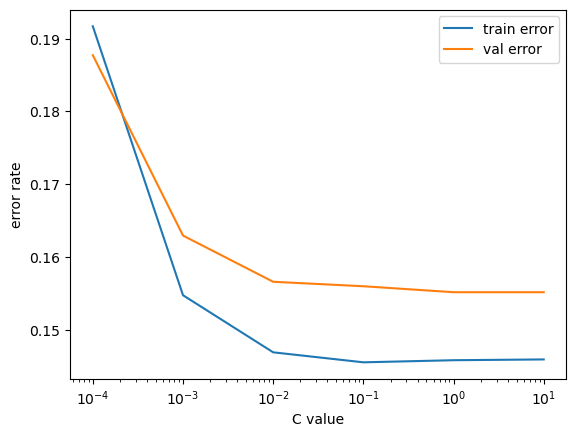

In [144]:
C_vals = [.0001,.001,.01,.1,1.,10.]; 

train_errors = []
val_errors  = []

for C in C_vals:
    # Train a logistic regression model with each inverse regularization C
    learner = LogisticRegression(C = C, random_state = seed)
    learner.fit(X_train, y_train)
    
    # Compute the training  error rates
    train_err = (y_train!= learner.predict(X_train)).mean()
    train_errors.append(train_err)

    # Compute the validation error rates
    val_err = (y_val!= learner.predict(X_val)).mean()
    val_errors.append(val_err)
    
# Plot the resulting performance as a function of C
plt.semilogx( C_vals, train_errors, label = 'train error');
plt.semilogx(C_vals, val_errors,  label = 'val error');
plt.xlabel("C value");
plt.ylabel("error rate");
plt.legend();

In [2441]:
model = LogisticRegression(C = 0.01)
model.fit(X_train, y_train)

# Compute the training  error rates
train_err = (y_train!= model.predict(X_train)).mean()
print(f"\nTraining error rate : ", train_err)

# Compute the validation error rates
val_err = (y_val!= model.predict(X_val)).mean()
print(f"\nvalidation error rate : ", val_err)

# Compute the tes error rates
test_err = (y_test!= model.predict(X_test)).mean()
print(f"\ntest error rate : ", test_err)


Training error rate :  0.1473478826420003

validation error rate :  0.15578300921187307

test error rate :  0.1493151526319022


## comparing models (random forest & xgboost)

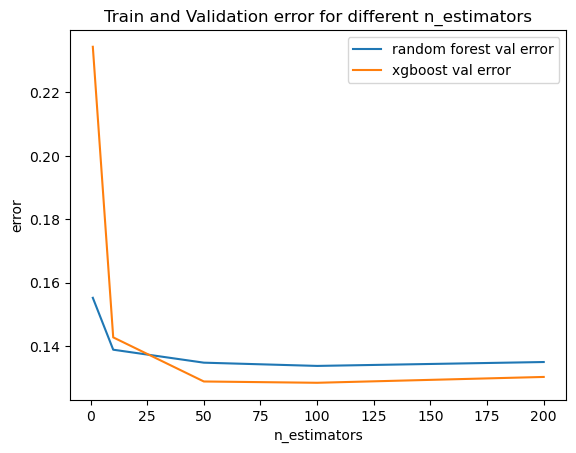

In [381]:
# number of trees to use in the ensemble
n_estimators = [1, 10, 50, 100,200]

rf_train_errors = []
rf_val_errors = []

xg_train_errors = []
xg_val_errors = []

for n in n_estimators: 
     RF =  RandomForestClassifier(random_state=seed, n_estimators = n, max_depth = 15, max_features = 0.5)
     RF.fit(X_train, y_train)

     xg=  xgb.XGBClassifier(max_depth =4, learning_rate = 0.25,  reg_alpha = 0.1, reg_lambda = 1, random_state=seed, n_estimators = n)
     xg.fit(X_train, y_train)
    
     # Compute the training  error rates
     train_err = (y_train!= RF.predict(X_train)).mean()
     rf_train_errors.append(train_err)

     # Compute the validation error rates
     val_err = (y_val!= RF.predict(X_val)).mean()
     rf_val_errors.append(val_err)

     # Compute the training  error rates
     train_err = (y_train!= xg.predict(X_train)).mean()
     xg_train_errors.append(train_err)

     # Compute the validation error rates
     val_err = (y_val!= xg.predict(X_val)).mean()
     xg_val_errors.append(val_err)

# Plot the resulting performance as a function of n estimate
#plt.plot(n_estimators , rf_train_errors,  label = 'rf train error');
plt.plot(n_estimators , rf_val_errors,    label = 'random forest val error');
#plt.plot(n_estimators , xg_train_errors,  label = 'xg train error');
plt.plot(n_estimators , xg_val_errors,    label = 'xgboost val error');

plt.xlabel('n_estimators')
plt.ylabel('error')
plt.title('Train and Validation error for different n_estimators')
plt.legend()
plt.show()